In [1]:
from src.potentials import Potentials_1D
from src.Integration.integrators import Integrators_1D
from src.Integration.integration_util import *


from src.MSM.class_MSM import *
from src.MSM.MSM_util import *
from src.MSM.MSM_util import _dtrajectory, _eigenvalues, _eigenvectors, _check_k,_timescales
from scipy.sparse.linalg import eigs
from src.MSM.its import *

from src.Reweighting.reweighting_util import g, Momega_EM, transition_propability_simple, Meta_EM #, Meta

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
import matplotlib.gridspec as gridspec
from scipy import integrate

In [2]:
## ACHTUNG ACHTE AUF ALLEN INPUT 
## ACHTE AUF LAGTIME UND BOLTZMANN 
## ACHTUNG: NOT HOw TO CUT THE TRAJECTORY

In [3]:
## Input plot
########################
nbins   = 100
lagTime = 100
x_line  = np.linspace(-2, 2, 1000)



In [4]:

Gradient_simple         = Potentials_1D.doublewell().gradient_simple
Potential_simple        = Potentials_1D.doublewell().potential_simple
Gradient_potential         = Potentials_1D.doublewell().gradient
Potential_potential        = Potentials_1D.doublewell().potential

Gradient_triple         = Potentials_1D.triplewell().gradient
Potential_triple        = Potentials_1D.triplewell().potential

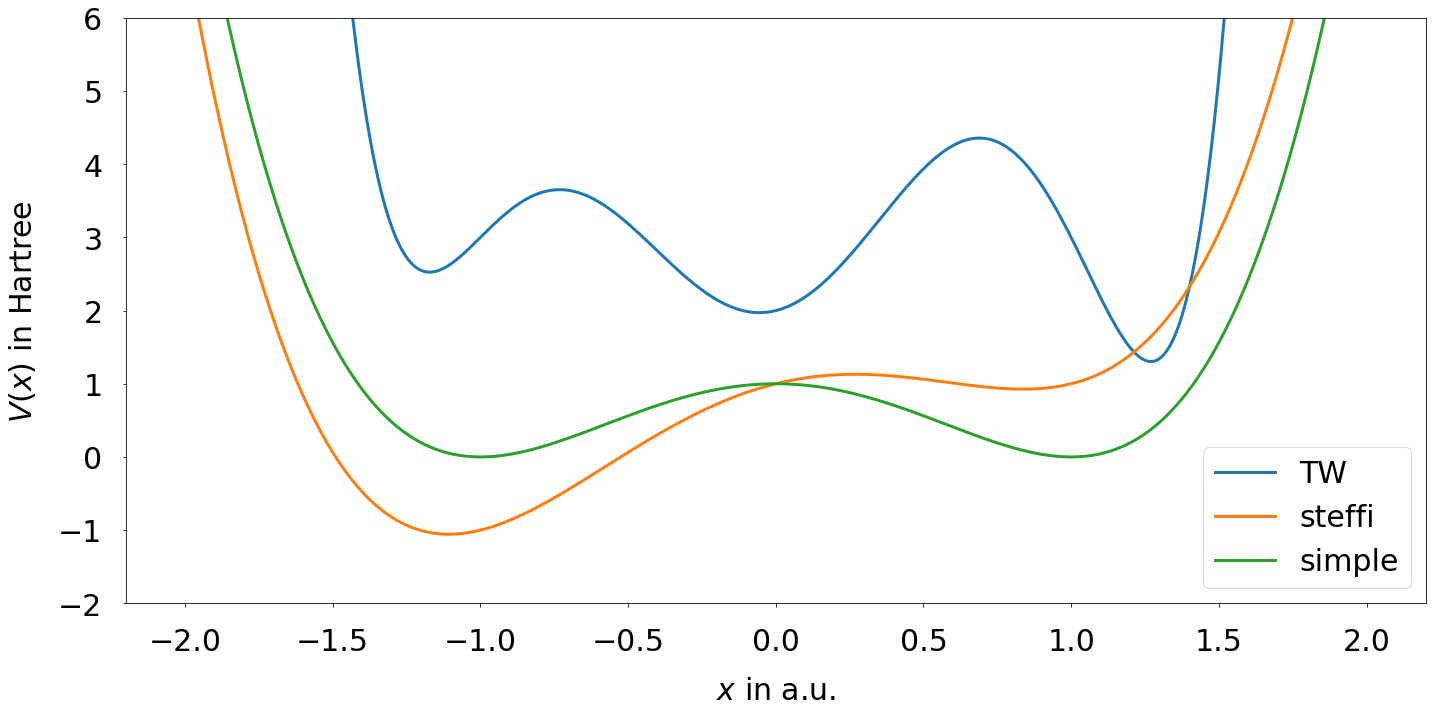

In [29]:
## test potential class
########################
TW  = Potentials_1D.triplewell()
DW  = Potentials_1D.doublewell()

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x_line,TW.potential(x_line), linewidth=3, label= 'TW')
ax.plot(x_line,DW.potential(x_line), linewidth=3, label= 'steffi')
ax.plot(x_line,DW.potential_simple(x_line), linewidth=3, label= 'simple')
        
                
ax.set_xlabel(r'$x$ in a.u.', fontsize=30, labelpad=20)
ax.set_ylabel(r'$V(x)$ in Hartree', fontsize=30, labelpad=20)
ax.tick_params(axis='both', labelsize=30, pad=20)
#ax.set_xlim(xLimits)
ax.set_ylim(-2,6)
            
ax.legend(fontsize=30) #prop=legendArgs)
fig.tight_layout()

In [ ]:
## Input Integrator
########################
kwargs_EM_sim_biased = { 
    'potential_gradient' : Potentials_1D.doublewell().gradient ,
    'position_init'      : 0      ,
    'momentum_init'      : 0      , 
    'n_steps'            : 10**7  ,
    'time_step'          : 0.0001   ,
    'temperature'        : 1.0   
}

kwargs_EM_tar_unbiased = { 
    'potential_gradient' : Potentials_1D.triplewell().gradient,
    'position_init'      : 0      ,
    'momentum_init'      : 0      , 
    'n_steps'            : 10**7  ,
    'time_step'          : 0.0001   ,
    'temperature'        : 1.0   
}

In [6]:
## EM
## generate or load trajectory
########################
#trajectory_from_integrator_EM_biased= Integrators_1D(**kwargs_EM_sim_biased).EulerMaruyama()
#np.save('Trajectory/DWpot_trajectory_eta_from_EM70001_biased',trajectory_from_integrator_EM_biased) 
trajectory_from_integrator_EM_biased = np.load('Trajectory/DWpot_trajectory_eta_from_EM70001_biased.npy', allow_pickle=True)
#
#trajectory_from_integrator_EM_unbiased= Integrators_1D(**kwargs_EM_tar_unbiased).EulerMaruyama()
#np.save('Trajectory/TWpot_trajectory_eta_from_EM70001_unbiased',trajectory_from_integrator_EM_unbiased)  
trajectory_from_integrator_EM_unbiased = np.load('Trajectory/TWpot_trajectory_eta_from_EM70001_unbiased.npy', allow_pickle=True)

## get hist and bins for plotting eigenvectors
hist_biased, bins_biased     = give_hist_bins(trajectory_from_integrator_EM_biased[0], nbins)
hist_unbiased, bins_unbiased = give_hist_bins(trajectory_from_integrator_EM_unbiased[0], nbins)



In [ ]:
## EM
## generate or load trajectory
########################

#trajectory_from_integrator_ISP_biased= Integrators_1D(**kwargs_ISP_sim_biased).ISP()
#np.save('Trajectory/test_trajectory_eta_from_ISP701_biased.npy',trajectory_from_integrator_ISP_biased) 
trajectory_from_integrator_ISP_biased = np.load('Trajectory/test_trajectory_eta_from_ISP701_biased.npy', allow_pickle=True)

#trajectory_from_integrator_ISP_unbiased= Integrators_1D(**kwargs_ISP_tar_unbiased).ISP()
#np.save('Trajectory/test_trajectory_eta_from_ISP701_unbiased',trajectory_from_integrator_ISP_unbiased)  
trajectory_from_integrator_ISP_unbiased = np.load('Trajectory/test_trajectory_eta_from_ISP701_unbiased.npy', allow_pickle=True)


## get hist and bins for plotting eigenvectors
hist_biased, bins_biased     = give_hist_bins(trajectory_from_integrator_ISP_biased[0], nbins)
hist_unbiased, bins_unbiased = give_hist_bins(trajectory_from_integrator_ISP_unbiased[0], nbins)



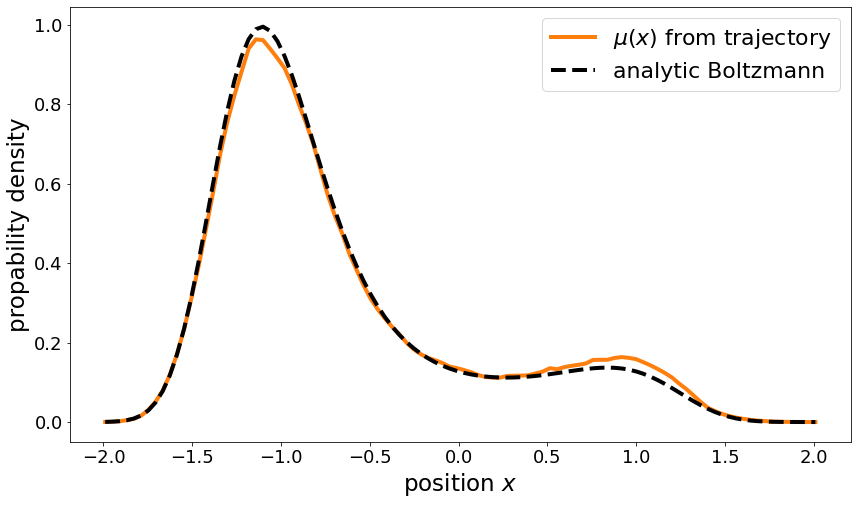

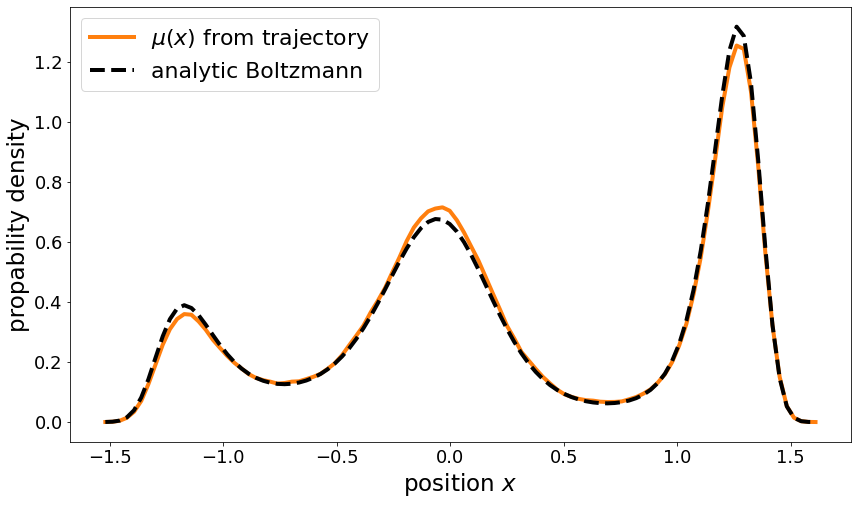

In [7]:
check_Boltzmann(trajectory_from_integrator_EM_biased[0],Potentials_1D.doublewell().potential)
check_Boltzmann(trajectory_from_integrator_EM_unbiased[0],Potentials_1D.triplewell().potential)

In [ ]:
## first steps for reweighting 
########################

In [8]:
def timed(fn):
    # make sure wherever u used this, imports will be ready
    from time import perf_counter
    from functools import wraps
    # wraps preserves the metadata of fn
    @wraps(fn)
    def inner(*args, **kwargs):
        start = perf_counter()
        result = fn(*args, **kwargs)
        end = perf_counter()
        elapsed = end - start
        args_ = [str(a) for a in args]
        kwargs_ = ["{0}={1}".format(k, v) for (k, v) in kwargs.items()]
        all_args = args_ + kwargs_
        args_str = ",".join(all_args)
        print("{0} ({1}) took {2:.6f} to run.".format(fn.__name__, args_str, elapsed))
        return result
    return inner

class Reweighting:
    
    def __init__(self, 
                 trajectory, 
                 dtrajectory,
                 random_number,
                 Potential_sim, 
                 Potential_tar,
                 Gradient_sim, 
                 Gradient_tar,
                 Pertubation,
                 lagTime,
                 stepsize,
                 kwargs_MSM,
                 Temperature,
                 Boltzmann
                ):
        
        ## make input nicer
        self.trajectory  = trajectory 
        
        if (random_number).all != None:
            self.eta_sim = random_number
        self.random_number = random_number
        
        ## make potential input clearer
        #if Potential != None:
        self.potential_simulation = Potential_sim
        self.potential_target     = Potential_tar
        self.gradient_simulation  = Gradient_sim
        self.gradient_target      = Gradient_tar 
        if Pertubation == None:
            self.U      = (self.potential_simulation,self.potential_target)
            self.U_grad = (self.gradient_simulation,self.gradient_target)    
            
            
        self.stepsize     = stepsize
        self.lag, self.itstau = lagTime, lagTime
        ## MSM: needed for correlation matrix
        _, self.bins, _, self._sliding, self._sparse_return, self._nstates, _ = kwargs_MSM

        ##
        self.Temperature     = Temperature      
        self.Boltzmann       = Boltzmann   
        
        if is_int_vector(dtrajectory): 
            self.dtrajectory = dtrajectory
        else:
            self.dtrajectory = _dtrajectory(self.trajectory, self.bins)
                    
            
        ## ADD: Boltzmann??
        ## for and ADD: visualisation module 
    #@timed
   # def dtrajectory(self, trajectory, bins):
   #     ''' This function give a discretized trajectory. The microstates are 
   #     associated to real numbers :math:`[0,nbins]`.'''
    #    return _dtrajectory(trajectory, bins)
    
    @timed
    def g_factor(self, traj, U, tau, beta=1.0):
        ''' This function give a function to calculate the reweighting factor g.'''
        return g(traj, U, tau, beta=1.0)
        
        ## ATTENTION UNCLEAR STRUCTURE WITH VELOCITY !!! all INTEGRATORS HAVE AN ADDITIONAL OUTPUT ETA
        ## mach all random_number eleganter
    @timed
    def M_factor(self):
        ''' This function give a function to calculate the reweighting factor M 
        corresponding to the used integration scheme.'''
        if (self.random_number).all != None:
            M_func = Meta_EM(self.trajectory, self.eta_sim, self.U_grad, self.lag, self.stepsize, kB=1.0, T=1.0, m=1.0, xi=1.0)    ## cooler machen
        else:
            M_func = Momega_EM(self.trajectory, self.U_grad, self.lag, self.stepsize) 
        return M_func


    @timed
    def count(self, dtraj, lag, reweighting_factor):
        return count_matrix_coo2_mult([dtraj], self.lag, reweighting_factor=reweighting_factor).toarray()
    
    def reweighted_transition_probability(self):
        g     = self.g_factor(self.trajectory, self.U, self.lag)
        M     = self.M_factor()
        #M_eta(self.trajectory, trajectory_from_integrator_EM_unbiased[1], self.U_grad, self.lag, self.stepsize, kB=1.0, T=1.0, m=1.0, xi=1.0) #Meta(self.eta_tar, self.eta_sim, self.lag)  # #
        # Momega_Euler_Maruyama(self.trajectory, self.U_grad, self.lag, self.stepsize) #
        print('M',M.shape)
        #dtraj = self.dtrajectory(self.trajectory, self.bins)
        
        C = self.count(self.dtrajectory[:-1], self.lag, (g[:-1],M)) #[:-1]
        #C     = count_matrix_coo2_mult([dtraj], self.lag, reweighting_factor=(g,M)).toarray()
        

        return transition_propability_simple(C)


In [9]:
## Input Reweighting biased to unbiased 
########################
dtrajectory = _dtrajectory(trajectory_from_integrator_EM_biased[0], nbins)

In [10]:
## Input Reweighting biased to unbiased 
########################

kwargs_MSM = { 
    'trajectory'     : None,
    'bins'           : nbins    ,
    'lag'            : lagTime  , 
    'sliding'        : True     ,
    'sparse_return'  : True     ,
    'nstates'        : None     ,
    'itstau'         : lagTime
}    

kwargs_Reweighting_model = { 
    'trajectory'     : trajectory_from_integrator_EM_biased[0],
    'dtrajectory'    : dtrajectory ,
    'Potential_sim'      : Potentials_1D.doublewell().potential ,
    'Potential_tar'      : Potentials_1D.triplewell().potential ,
    'Gradient_sim'      : Potentials_1D.doublewell().gradient ,
    'Gradient_tar'      : Potentials_1D.triplewell().gradient ,
    'Pertubation'    : None     ,
    'lagTime'       : lagTime,
    'kwargs_MSM'     : kwargs_MSM.values()  ,
    'stepsize'       : 0.0001 ,
    'random_number'  : trajectory_from_integrator_EM_biased[1],
    'Temperature'    : 1.0      ,
    'Boltzmann'      : 1.0      
}
RW_model = Reweighting(**kwargs_Reweighting_model)

In [ ]:
## ATTENTIOAN input transition in MSM is to modify to avoid double calulation of d trajectory

###                                                                  ###

 ##          DONOT USE IF YOU PLAY WITH traj 10^8 EM 0,001           ##

###                                                                  ###

## different MSM models
########################
## implied time scales 
########################
#tau  = [50, 75, 150] #[10, 20, 30, 50] #[50, 100, 150]

lagTime = 100

## Input biased MSM
########################
kwargs_MSM_model_biased = { 
    'trajectory'     : trajectory_from_integrator_EM_biased[0],
    'bins'           : nbins    ,
    'lag'            : lagTime  , 
    'sliding'        : True     ,
    'sparse_return'  : True     ,
    'nstates'        : None     ,
    'itstau'         : lagTime
} 
## initialize MSM
MSM_model_biased = MSM(**kwargs_MSM_model_biased)
## AVOID DOUBLE CALCULATION OF DTRAJECTORY
T_biased     = MSM_model_biased.transition_matrix_reversible_pisym()
## eigenvalues//eigenvectors
k        = 4 #_check_k(T_RW, k=None)
lamb_biased  = _eigenvalues(T_biased , k=k, reversible=False, mu=None)
l_biased     = _eigenvectors(T_biased, k=k, right=None, reversible=False, mu=None)
## ITS
#ITS_biased  , Lambda_biased   = timescales_for_tau_list(trajectory_from_integrator_EM_biased[0],tau,nbins, k=2)

## Input unbiased MSM
########################
kwargs_MSM_model_unbiased = { 
    'trajectory'     : trajectory_from_integrator_EM_unbiased[0],
    'bins'           : nbins  ,
    'lag'            : lagTime  , 
    'sliding'        : True     ,
    'sparse_return'  : True     ,
    'nstates'        : None     ,
    'itstau'         : lagTime
} 
## initialize MSM
MSM_model_unbiased = MSM(**kwargs_MSM_model_unbiased)
## AVOID DOUBLE CALCULATION OF DTRAJECTORY
T_unbiased     = MSM_model_unbiased.transition_matrix_reversible_pisym()
## eigenvalues//eigenvectors
k        = 4 #_check_k(T_RW, k=None)
lamb_unbiased  = _eigenvalues(T_unbiased , k=k, reversible=False, mu=None)
l_unbiased    = _eigenvectors(T_unbiased, k=k, right=None, reversible=False, mu=None)
## ITS
# ITS_unbiased  , Lambda_unbiased   = timescales_for_tau_list(trajectory_from_integrator_EM_unbiased[0],tau,nbins, k=2)



In [11]:
## load vecs and values
########################
#np.save('Eigenvalues/from_TWpot_EM70001_unbiased',l_unbiased)  
l_unbiased = np.load('Eigenvalues/from_TWpot_EM70001_unbiased.npy', mmap_mode='r')
#np.save('Eigenvectors/from_TWpot_EM70001_unbiased',l_unbiased)  
l_unbiased = np.load('Eigenvectors/from_TWpot_EM70001_unbiased.npy', mmap_mode='r')

#np.save('Eigenvalues/from_DWpot_EM70001_biased',l_biased)  
l_biased = np.load('Eigenvalues/from_DWpot_EM70001_biased.npy', mmap_mode='r')
#np.save('Eigenvectors/from_DWpot_EM70001_biased',l_biased)  
l_biased = np.load('Eigenvectors/from_DWpot_EM70001_biased.npy', mmap_mode='r')

In [12]:
## ADD dtrajectory 


## Input Reweighting biased to unbiased 
########################
kwargs_Reweighting_model = { 
    'trajectory'     : trajectory_from_integrator_EM_biased[0],
    'dtrajectory'    : dtrajectory ,
    'Potential_sim'      : Potentials_1D.doublewell().potential ,
    'Potential_tar'      : Potentials_1D.triplewell().potential ,
    'Gradient_sim'      : Potentials_1D.doublewell().gradient ,
    'Gradient_tar'      : Potentials_1D.triplewell().gradient ,
    'Pertubation'    : None     ,
    'lagTime'       : lagTime,
    'kwargs_MSM'     : kwargs_MSM.values()  ,
    'stepsize'       : 0.0001 ,
    'random_number'  : trajectory_from_integrator_EM_biased[1],
    'Temperature'    : 1.0      ,
    'Boltzmann'      : 1.0      
}

RW_model = Reweighting(**kwargs_Reweighting_model)
T_RW     = RW_model.reweighted_transition_probability()

## ATTENTION THIS TAKES TOO LONG 
## eigenvalues//eigenvectors
lamb_RW  = _eigenvalues(T_RW , k=None, reversible=False, mu=None)
k        = 4 #_check_k(T_RW, k=None)
l_RW     = _eigenvectors(T_RW, k=k, right=None, reversible=False, mu=None)

g_factor (<__main__.Reweighting object at 0x7fdbbd85be90>,[ 0.         -0.02063539 -0.00162052 ... -1.50763678 -1.49916354
 -1.48823842],(<bound method Potentials_1D.doublewell.potential of <src.potentials.Potentials_1D.doublewell object at 0x7fdbbd85b750>>, <bound method Potentials_1D.triplewell.potential of <src.potentials.Potentials_1D.triplewell object at 0x7fdbbd85b1d0>>),100) took 1.035885 to run.
M_factor (<__main__.Reweighting object at 0x7fdbbd85be90>) took 1.089692 to run.
M (9999900,)
count (<__main__.Reweighting object at 0x7fdbbd85be90>,[49 49 49 ... 12 12 12],100,(array([0.36787944, 0.36615796, 0.36786881, ..., 0.00487747, 0.00430785,
       0.00411266]), array([0.70897144, 0.69760813, 0.6863448 , ..., 0.05682215, 0.06995896,
       0.08762432]))) took 0.492642 to run.


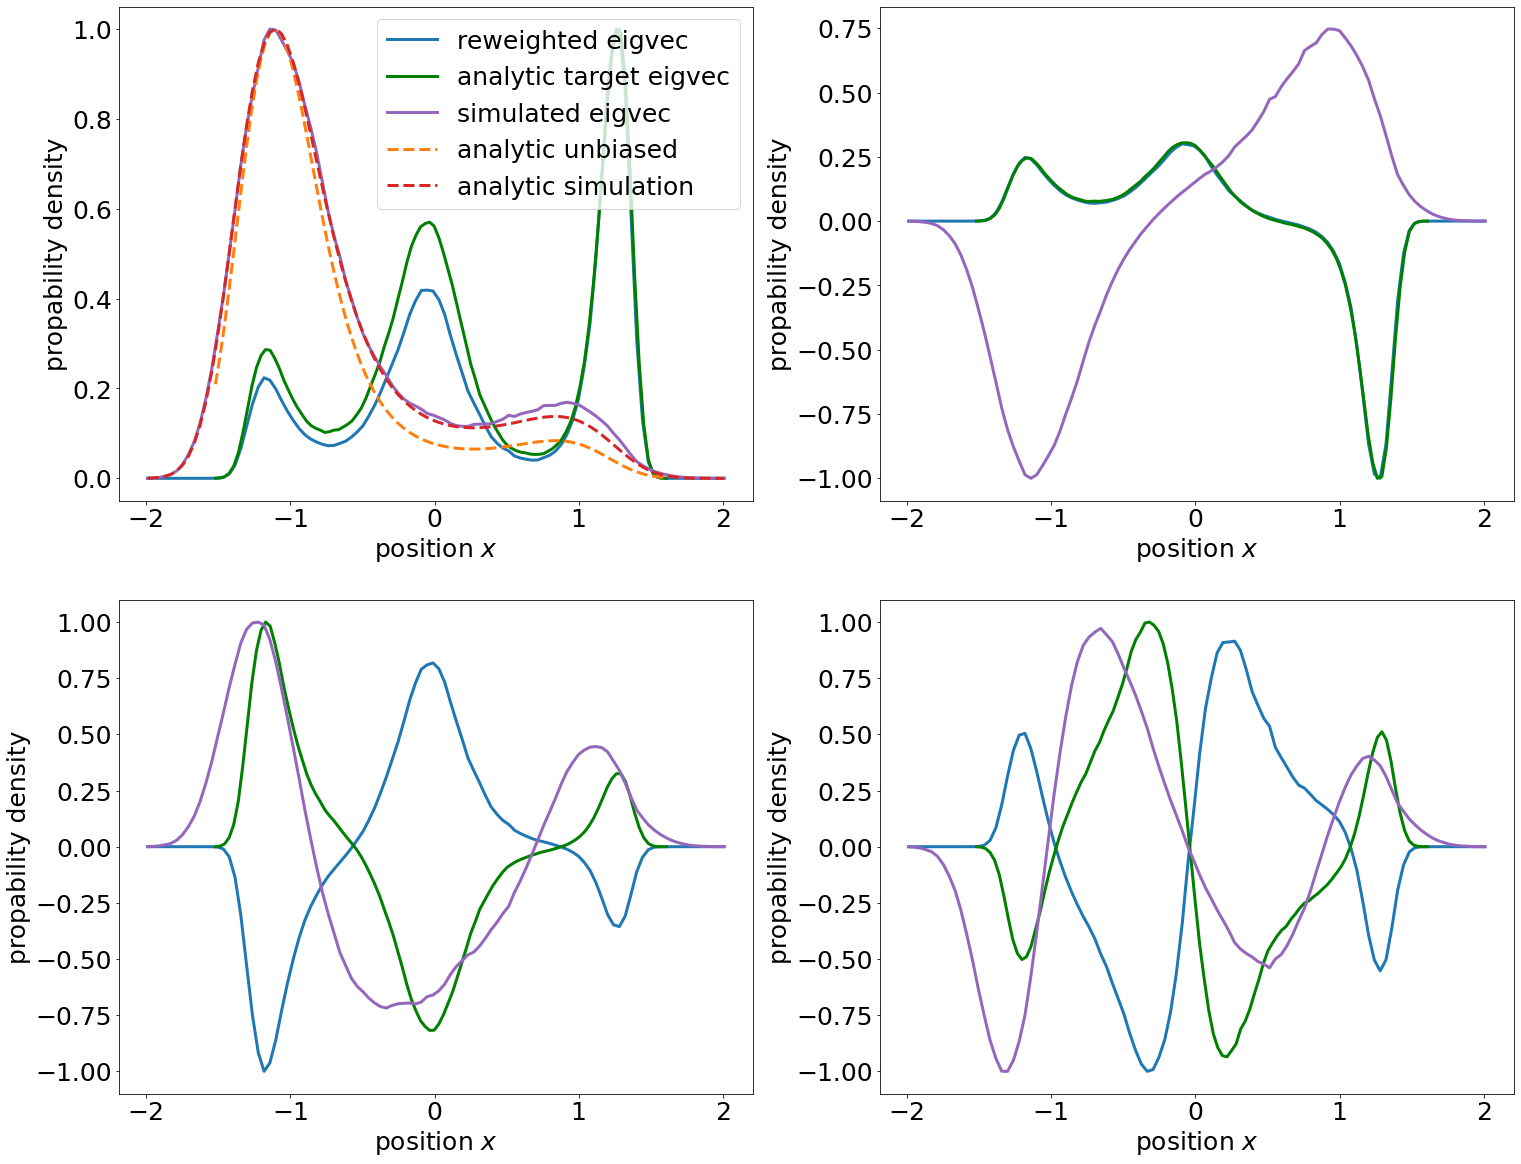

In [15]:
## Check eigenvectors 
########################

## ACHTUNG MIT BINS WAS NICHT OKAY


fig, axes = plt.subplots(2, 2, figsize=(25, 20))
for ax, i in zip(axes.flat, range(l_RW.shape[1])): 
    
    ## eigenvectors of reweighted transition matrix
    eigenvec_RW = l_RW[:,i]/max(abs(l_RW[:,i]))
    ax.plot(bins_biased,eigenvec_RW,lw=3,label='reweighted eigvec')

    ## eigenvectors of target transition matrix
    eigenvec_unbiased = -l_unbiased[:,i]/max(abs(l_unbiased[:,i]))
    ax.plot(bins_unbiased,eigenvec_unbiased,lw=3, color='green',label='analytic target eigvec')
    
    ## eigenvectors of reweighted transition matrix
    eigenvec_biased = l_biased[:,i]/max(abs(l_biased[:,i]))
    ax.plot(bins_biased,eigenvec_biased,lw=3, color='C4',label='simulated eigvec')
    
    ax.set_xlabel(r'position $x$',fontsize=25)
    ax.set_ylabel(r'propability density',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    if i == 0:
        ana_boltz=analytic_Boltzmann(Potentials_1D.doublewell().potential_target, bins_unbiased)
        ax.plot(bins_unbiased, ana_boltz/max(ana_boltz)
                ,'--',lw=3, c='C1', label='analytic unbiased')
        ana_boltz=analytic_Boltzmann(Potentials_1D.doublewell().potential_simulation, bins_biased)
        ax.plot(bins_biased, ana_boltz/max(ana_boltz)
                ,'--',lw=3, c='C3', label='analytic simulation')
        #ax.plot(bins_unbiased, hist_unbiased,'--', c='C2', label='MSM analytic unbiased')
    
        ax.legend(fontsize=25)
   # d = np.zeros(len(bins))
    #ax.fill_between(bins, eigenvec, where=-l[:,i]>=d, interpolate=True, color='C0', alpha=0.3)
   # ax.fill_between(bins, eigenvec, where=-l[:,i]<=d, interpolate=True, color='C4', alpha=0.3)

In [16]:
tau  = [10, 50, 100, 150, 200, 300, 500]

In [17]:
## MAKE FUNCTION     
ITS=[]
Lambda=[]

for t in tau:
    ## SO IST DAS SCHEISE WEIL LAG TIME NICHT VARIABLE
    kwargs_Reweighting_its = { 
    'trajectory'     : trajectory_from_integrator_EM_biased[0],
    'dtrajectory'    : dtrajectory ,
    'Potential_sim'      : Potentials_1D.doublewell().potential ,
    'Potential_tar'      : Potentials_1D.triplewell().potential ,
    'Gradient_sim'      : Potentials_1D.doublewell().gradient ,
    'Gradient_tar'      : Potentials_1D.triplewell().gradient ,
    'Pertubation'    : None     ,
        'lagTime'        : t,
        'kwargs_MSM'     : kwargs_MSM.values()  ,
        'stepsize'       : 0.0001 ,
        'random_number'  : trajectory_from_integrator_EM_biased[1],
        'Temperature'    : 1.0      ,
        'Boltzmann'      : 1.0      
    }
    
    RW_model = Reweighting(**kwargs_Reweighting_its)
    T_RW     = RW_model.reweighted_transition_probability()
    ## eigenvalues//eigenvectors
    k        = 4
    its, values = _timescales(T_RW , tau=t, k=k, reversible=False, mu=None)
    
    ITS.append(its[1:k])
    Lambda.append(values[1:k].real)
    
ITS   = np.array(ITS)
Lambda= np.array(Lambda)

g_factor (<__main__.Reweighting object at 0x7fdbbd44acd0>,[ 0.         -0.02063539 -0.00162052 ... -1.50763678 -1.49916354
 -1.48823842],(<bound method Potentials_1D.doublewell.potential of <src.potentials.Potentials_1D.doublewell object at 0x7fdbbd44aad0>>, <bound method Potentials_1D.triplewell.potential of <src.potentials.Potentials_1D.triplewell object at 0x7fdbbd44a8d0>>),10) took 0.994672 to run.
M_factor (<__main__.Reweighting object at 0x7fdbbd44acd0>) took 1.087553 to run.
M (9999990,)
count (<__main__.Reweighting object at 0x7fdbbd44acd0>,[49 49 49 ... 12 12 12],10,(array([3.67879441e-01, 3.66157964e-01, 3.67868813e-01, ...,
       3.32858736e-04, 2.73442439e-04, 6.66574482e-04]), array([1.010167  , 1.01065771, 0.99952073, ..., 0.32770092, 0.4345128 ,
       0.34274018]))) took 0.538769 to run.
g_factor (<__main__.Reweighting object at 0x7fdbbd668bd0>,[ 0.         -0.02063539 -0.00162052 ... -1.50763678 -1.49916354
 -1.48823842],(<bound method Potentials_1D.doublewell.potenti

In [18]:

## different MSM models
########################
## implied time scales 
########################
#tau  = [50, 75, 150] #[10, 20, 30, 50] #[50, 100, 150]


## Input biased MSM
########################
## ITS
ITS_biased  , Lambda_biased   = timescales_for_tau_list(trajectory_from_integrator_EM_biased[0],tau,nbins, k=4)

## Input unbiased MSM
########################
## ITS
ITS_unbiased  , Lambda_unbiased   = timescales_for_tau_list(trajectory_from_integrator_EM_unbiased[0],tau,nbins, k=4)



dtrajectory (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>) took 1.662507 to run.
count_matrix (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>) took 2.122612 to run.
dtrajectory (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>) took 1.678253 to run.
count_matrix (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>) took 2.121848 to run.
transition_matrix_non_reversible (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>) took 2.122270 to run.
stationary_distribution (<src.MSM.class_MSM.MSM object at 0x7fdbbd4438d0>,[[0.15384615 0.44230769 0.25       ... 0.         0.         0.        ]
 [0.10622711 0.26007326 0.35897436 ... 0.         0.         0.        ]
 [0.0157385  0.11380145 0.3401937  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.14814815 0.14814815 0.07407407]
 [0.         0.         0.         ... 0.         0.25       0.3125    ]
 [0.         0.         0.         ... 0.25       0.375      0.125     ]]) took 0.000968 to run.
transition_

dtrajectory (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>) took 1.624194 to run.
count_matrix (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>) took 2.085299 to run.
dtrajectory (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>) took 1.703471 to run.
count_matrix (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>) took 2.144190 to run.
transition_matrix_non_reversible (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>) took 2.144415 to run.
stationary_distribution (<src.MSM.class_MSM.MSM object at 0x7fdbbd443590>,[[0.         0.         0.23404255 ... 0.         0.         0.        ]
 [0.         0.01639344 0.04262295 ... 0.         0.         0.        ]
 [0.         0.00887574 0.03032544 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00575374 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]) took 0.001115 to run.
transition_

In [19]:
## VISUALIZE 

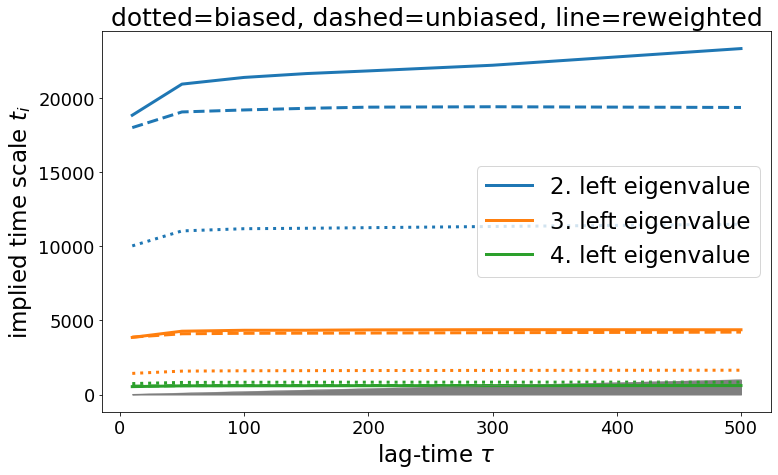

In [26]:

its     = plt.figure(figsize=(12,7))
spec5  = gridspec.GridSpec(1,1, hspace=0.4, wspace=0.4)
Pic=[]
ax = its.add_subplot(spec5[0, 0])

ax.set_title(r'dotted=biased, dashed=unbiased, line=reweighted', fontsize=25)

ax.set_xlabel(r'lag-time $\tau$', fontsize=23)
ax.set_ylabel(r'implied time scale $t_i$', fontsize=23)
for p in range(3):
    pic = ax.plot(np.array(tau),ITS_biased[:,p],':',lw=3,color='C'+str(p),label=str(p))
    pic = ax.plot(np.array(tau),ITS_unbiased[:,p],'--',lw=3,color='C'+str(p),label=str(p))
    pic = ax.plot(np.array(tau),ITS[:,p],lw=3,color='C'+str(p),label=str(p))
    Pic.append(pic[0])
    
ax.plot(tau,np.array(tau)*2, color='C7', lw=0.4)
H = np.array(tau)*2
d = np.zeros(len(tau))
ax.fill_between(tau, H, where=H>=d, interpolate=True, color='C7')
ax.legend(Pic,['2. left eigenvalue','3. left eigenvalue','4. left eigenvalue','5. left eigenvalue','6. left eigenvalue','7. left eigenvalue'],loc='center right', fontsize=23)

ax.tick_params(axis='both', which='major', labelsize=18)

    #plt.savefig('/home/schaefej51/Documents/Peptide/RESULTS/msm_1D_2_its.png' , bbox_inches='tight', format='png')
    


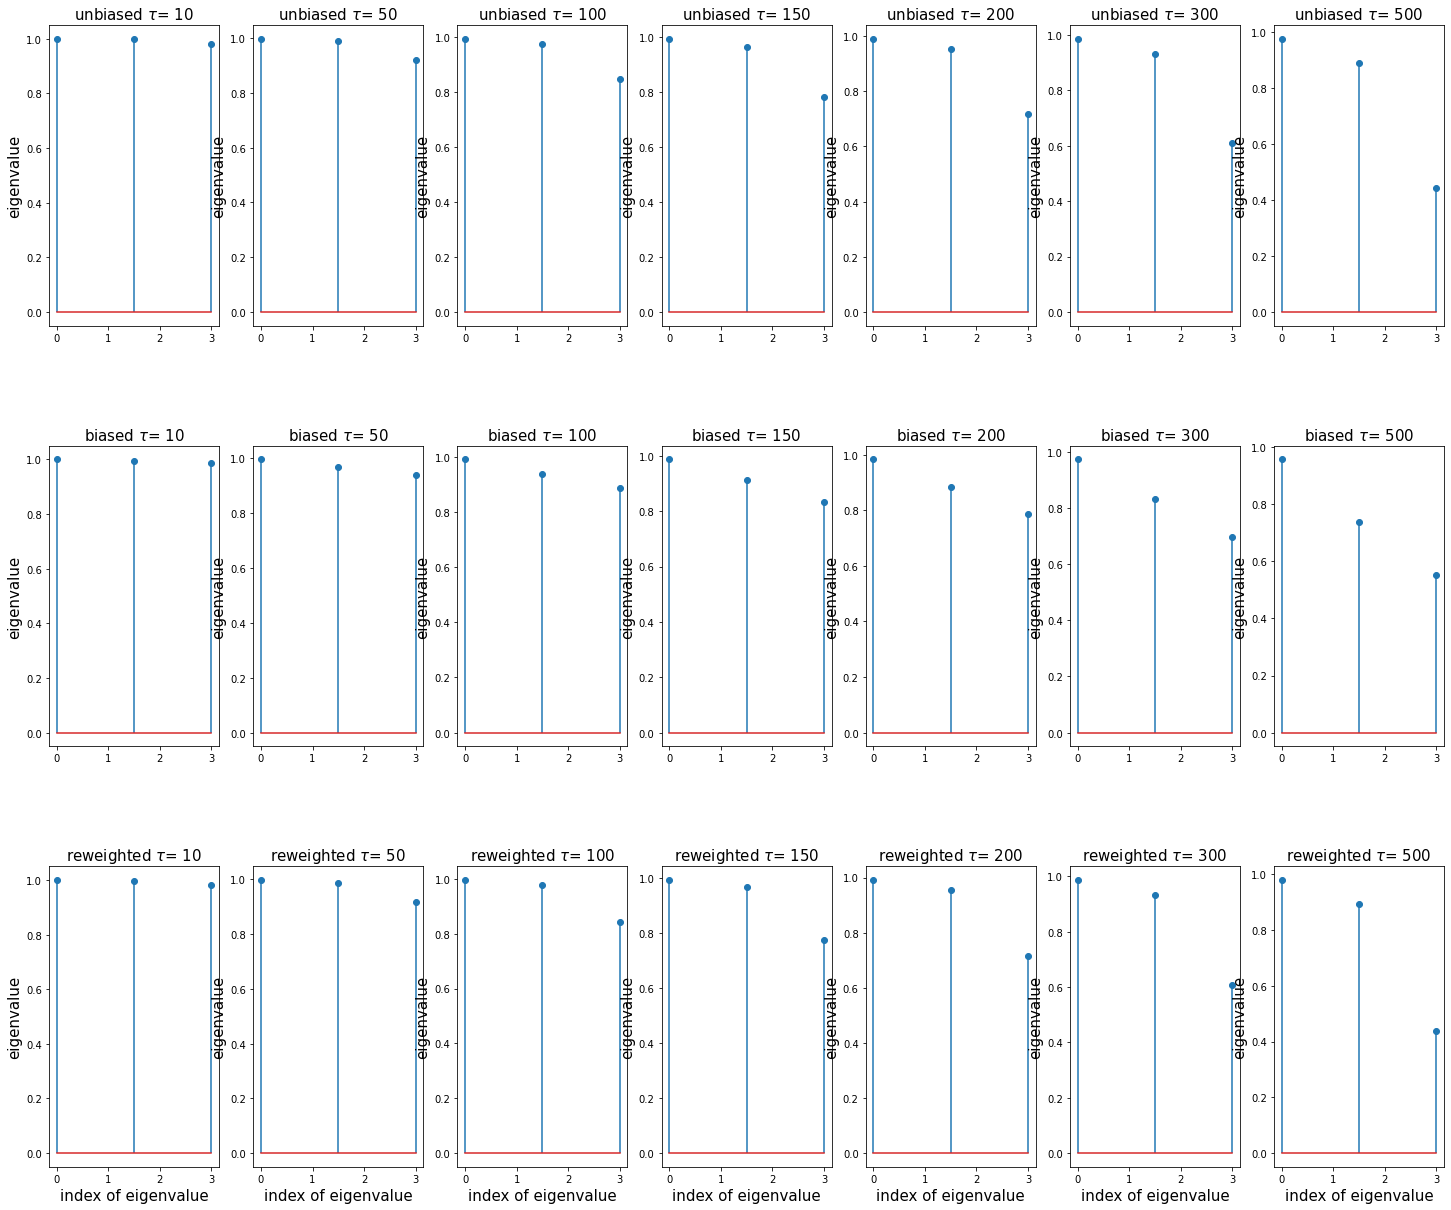

In [21]:
ev     = plt.figure(figsize=(25,len(tau)*3))
spec5  = gridspec.GridSpec( 3,len(tau),  hspace=0.4, wspace=0.2)
a      = list()
images = list()

for col in range(len(tau)):
    ax = ev.add_subplot(spec5[0, col])        
    ax.set_ylabel(r'eigenvalue',fontsize=15)

    ax.set_title(r'unbiased $\tau$= '+str(tau[col]), fontsize=15)
    x = np.linspace(0,len(Lambda_unbiased[col]),len(Lambda_unbiased[col]))
    y_unbiased = Lambda_unbiased[col]
    ax.stem(x, y_unbiased , use_line_collection=True)

    
    ax = ev.add_subplot(spec5[1, col])
    ax.set_title(r'biased $\tau$= '+str(tau[col]), fontsize=15)
    ax.set_ylabel(r'eigenvalue',fontsize=15)
    x = np.linspace(0,len(Lambda_biased[col]),len(Lambda_biased[col]))
    y_biased = Lambda_biased[col]
    ax.stem(x, y_biased , use_line_collection=True)

    ax = ev.add_subplot(spec5[2, col])
    ax.set_ylabel(r'eigenvalue',fontsize=15)
    ax.set_title(r'reweighted $\tau$= '+str(tau[col]), fontsize=15)
    x = np.linspace(0,len(Lambda[col]),len(Lambda[col]))
    y = Lambda[col]
    ax.stem(x, y , use_line_collection=True)
    ax.set_xlabel(r'index of eigenvalue',fontsize=15)    
#plt.savefig('/home/schaefej51/Documents/Peptide/RESULTS/msm_1D_2_lamb.png' , bbox_inches='tight', format='png')